In [2]:
#
import numpy as np
import os, sys

sys.path.insert(0, '/global/homes/q/qmxp55/DESI/bgstargets/py')

from io_ import get_sweep_whole, getBGSbits
from io_ import get_random, get_isdesi, get_dict, bgsmask, get_reg
from cuts import getGeoCuts, get_bgs, flux_to_mag
from QA import getStats, flow

sys.path.insert(0, '/global/homes/q/qmxp55/DESI/bgs_main/')
from desitarget.cuts import select_targets
from desitarget import io, cuts
from desitarget.sv1 import sv1_cuts
from desitarget.sv3 import sv3_cuts

import healpy as hp
import astropy.io.fits as fits
from astropy.coordinates import SkyCoord
import astropy.units as units
import fitsio
import matplotlib.pyplot as plt
from astropy.table import Table

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

# Steeps to update DESITARGET

1) `git fetch upstream` \
2) create new branch based on `upstream/master` branch \
3) commit changes \
4) push with `git push origin <new_branch>`

In [15]:

def runtest(rff=False, targtype="bright", primary1=False, file=None, survey='main', south=True, option=1):
    
    if file is None: raise ValueError('Select a file from SWEEPS, TRACTOR or DESITARGET-like')
    targets = Table.read(file)
    
    if south:
        targets['PHOTSYS'] = 'S'
    else:
        targets['PHOTSYS'] = 'N'
    

    if option == 1:
    
        photsys_north, photsys_south, obs_rflux, gflux, rflux, zflux,                     \
            w1flux, w2flux, gfiberflux, rfiberflux, zfiberflux,                           \
            gfibertotflux, rfibertotflux, zfibertotflux,                                  \
            objtype, release, ra, dec, gfluxivar, rfluxivar, zfluxivar, w1fluxivar,       \
            gnobs, rnobs, znobs, gfracflux, rfracflux, zfracflux,                         \
            gfracmasked, rfracmasked, zfracmasked,                                        \
            gfracin, rfracin, zfracin, gallmask, rallmask, zallmask,                      \
            gsnr, rsnr, zsnr, w1snr, w2snr, dchisq, deltaChi2, maskbits, refcat =         \
             cuts._prepare_optical_wise(objects=targets, mask=True)

        gaia, pmra, pmdec, parallax, parallaxovererror, parallaxerr, gaiagmag, \
        gaiabmag, gaiarmag, gaiaaen, gaiadupsource, Grr, gaiaparamssolved, \
        gaiabprpfactor, gaiasigma5dmax, galb = \
        cuts._prepare_gaia(objects=targets, colnames=None)
    
    elif option == 2:
    
        flux = cuts.unextinct_fluxes(targets)
        gflux = flux['GFLUX']
        rflux = flux['RFLUX']
        zflux = flux['ZFLUX']
        w1flux = flux['W1FLUX']
        w2flux = flux['W2FLUX']
        zfiberflux = flux['ZFIBERFLUX']
        rfiberflux = flux['RFIBERFLUX']
        
        rfibertotflux = targets['FIBERTOTFLUX_R']
        objtype = targets['TYPE']

        gfluxivar = targets['FLUX_IVAR_G']
        rfluxivar = targets['FLUX_IVAR_R']
        zfluxivar = targets['FLUX_IVAR_Z']

        gsnr = targets['FLUX_G'] * np.sqrt(targets['FLUX_IVAR_G'])
        rsnr = targets['FLUX_R'] * np.sqrt(targets['FLUX_IVAR_R'])
        zsnr = targets['FLUX_Z'] * np.sqrt(targets['FLUX_IVAR_Z'])
        w1snr = targets['FLUX_W1'] * np.sqrt(targets['FLUX_IVAR_W1'])
        w2snr = targets['FLUX_W2'] * np.sqrt(targets['FLUX_IVAR_W2'])

        dchisq = targets['DCHISQ']
        deltaChi2 = dchisq[..., 0] - dchisq[..., 1]

        gnobs, rnobs, znobs = targets['NOBS_G'], targets['NOBS_R'], targets['NOBS_Z']
        gallmask = targets['ALLMASK_G']
        rallmask = targets['ALLMASK_R']
        zallmask = targets['ALLMASK_Z']
        gfracflux = targets['FRACFLUX_G']
        rfracflux = targets['FRACFLUX_R']
        zfracflux = targets['FRACFLUX_Z']
        gfracmasked = targets['FRACMASKED_G']
        rfracmasked = targets['FRACMASKED_R']
        zfracmasked = targets['FRACMASKED_Z']
        gfracin = targets['FRACIN_G']
        rfracin = targets['FRACIN_R']
        zfracin = targets['FRACIN_Z']
        maskbits = targets['MASKBITS']
        refcat = targets['REF_CAT']

        gaiagmag = targets['GAIA_PHOT_G_MEAN_MAG']
        Grr = gaiagmag - 22.5 + 2.5*np.log10(targets['FLUX_R'])
    
#     gaiadupsource = targets['GAIA_DUPLICATED_SOURCE']
#     if issubclass(gaiadupsource.dtype.type, np.integer):
#         if len(set(np.atleast_1d(gaiadupsource)) - set([0, 1])) == 0:
#             gaiadupsource = targets['GAIA_DUPLICATED_SOURCE'].astype(bool)

    if 'BRICK_PRIMARY' in targets.colnames:
        primary = targets['BRICK_PRIMARY']
    else:
        primary = np.ones_like(gflux, dtype='?')
    
    if rff: ff = rfiberflux
    else: ff = None
    
    if primary1: prim = primary
    else: prim = None
    
    if survey == 'main':
        print('-------- getting BGS MAIN targets --------')
        bgs = cuts.isBGS(
            rfiberflux=ff, gflux=gflux, rflux=rflux,
            zflux=zflux, w1flux=w1flux, w2flux=w2flux,
            gnobs=gnobs, rnobs=rnobs, znobs=znobs,
            gfracmasked=gfracmasked, rfracmasked=rfracmasked,
            zfracmasked=zfracmasked, gfracflux=gfracflux,
            rfracflux=rfracflux, zfracflux=zfracflux,
            gfracin=gfracin, rfracin=rfracin, zfracin=zfracin,
            gfluxivar=gfluxivar, rfluxivar=rfluxivar,
            zfluxivar=zfluxivar, maskbits=maskbits,
            Grr=Grr, refcat=refcat, w1snr=w1snr, gaiagmag=gaiagmag,
            primary=prim, targtype=targtype)
    elif survey == 'sv':
        print('-------- getting BGS SV targets --------')
        bgs = sv1_cuts.isBGS(
            gflux=gflux, rflux=rflux, zflux=zflux, w1flux=w1flux, w2flux=w2flux,
            rfiberflux=ff, gnobs=gnobs, rnobs=rnobs, znobs=znobs,
            gfracmasked=gfracmasked, rfracmasked=rfracmasked, zfracmasked=zfracmasked,
            gfracflux=gfracflux, rfracflux=rfracflux, zfracflux=zfracflux,
            gfracin=gfracin, rfracin=rfracin, zfracin=zfracin,
            gfluxivar=gfluxivar, rfluxivar=rfluxivar, zfluxivar=zfluxivar,
            maskbits=maskbits, Grr=Grr, refcat=refcat, w1snr=w1snr, gaiagmag=gaiagmag,
            objtype=objtype, primary=prim, targtype=targtype)
    elif survey == 'sv3':
        print('-------- getting BGS SV3 targets --------')
        bgs = sv3_cuts.isBGS(
            gflux=gflux, rflux=rflux, zflux=zflux, w1flux=w1flux, w2flux=w2flux, rfibertotflux=rfibertotflux,
            rfiberflux=ff, gnobs=gnobs, rnobs=rnobs, znobs=znobs,
            gfluxivar=gfluxivar, rfluxivar=rfluxivar, zfluxivar=zfluxivar,
            maskbits=maskbits, Grr=Grr, refcat=refcat, w1snr=w1snr, w2snr=w2snr, gaiagmag=gaiagmag,
            objtype=objtype, primary=prim, south=south, targtype=targtype)
        
    else: raise ValueError('%s is not a valid survey programme.' %(survey))
                    
    return bgs

## BGS assess comparison DESITARGET with MYCODE for DR8

### MAIN

In [3]:
#run my bgs script on one sweep brick
mastercat = '/global/project/projectdirs/cosmo/data/legacysurvey/dr8/south/sweep/8.0/sweep-190p000-200p005.fits'
cat = getBGSbits(mycatpath=mastercat, outdir=None, mycat=True, getmycat=True)

---- BGSMASK key: ---- 
	 BS, 0, 1
	 MS, 1, 2
	 GC, 2, 4
	 LG, 3, 8
	 allmask, 4, 16
	 nobs, 5, 32
	 SG, 6, 64
	 SGSV, 7, 128
	 FMC, 8, 256
	 FMC2, 9, 512
	 CC, 10, 1024
	 QC_FM, 11, 2048
	 QC_FI, 12, 4096
	 QC_FF, 13, 8192
	 QC_FM2, 14, 16384
	 QC_FI2, 15, 32768
	 QC_FF2, 16, 65536
	 QC_IVAR, 17, 131072
	 bgs_any, 20, 1048576
	 bgs_bright, 21, 2097152
	 bgs_faint, 22, 4194304
	 bgs_sv_any, 30, 1073741824
	 bgs_sv_bright, 31, 2147483648
	 bgs_sv_faint, 32, 4294967296
	 bgs_sv_faint_ext, 33, 8589934592
	 bgs_sv_fibmag, 34, 17179869184
	 bgs_sv_lowq, 35, 34359738368
	 bgs_sv_any_wqc, 36, 68719476736
	 bgs_sv_lowq_wqc, 37, 137438953472
---- Sanity Check ---- 
	 BS, 3877196, 3877196
	 MS, 3833058, 3833058
	 GC, 3949441, 3949441
	 LG, 3944628, 3944628
	 allmask, 3938037, 3938037
	 nobs, 3948722, 3948722
	 SG, 3766688, 3766688
	 SGSV, 3767362, 3767362
	 FMC, 3934112, 3934112
	 FMC2, 3934643, 3934643
	 CC, 3776143, 3776143
	 QC_FM, 3916707, 3916707
	 QC_FI, 3947746, 3947746
	 QC_FF, 3927141, 

In [4]:
#run desitarget on the same sweep brick
#see: /global/homes/q/qmxp55/DESI/bgs_main/select_targets_bgs.py
#cat1 = fitsio.read('/global/cscratch1/sd/qmxp55/desitarget_output/test_lslga_1.fits/targets/main/resolve/targets-drX-hp-X.fits')
cat1b = runtest(rff=True, targtype='bright', primary1=False, file=mastercat)
cat1f = runtest(rff=True, targtype='faint', primary1=False, file=mastercat)

-------- getting BGS MAIN targets --------
-------- getting BGS MAIN targets --------


In [7]:
#bgsf1 = (cat1f['BGS_TARGET'] & 2**(0)) != 0
#bgsb1 = (cat1b['BGS_TARGET'] & 2**(1)) != 0

bgsb = ((cat['BGSBITS'] & 2**(21)) != 0)
bgsf = ((cat['BGSBITS'] & 2**(22)) != 0)
bgs = ((cat['BGSBITS'] & 2**(20)) != 0)

In [8]:
print('Targ. Dens. of BGS faint: %.3f (DESITARGET) \t %.3f (MYCODE)' %(np.sum(cat1f)/47, np.sum(bgsf)/47))
print('Targ. Dens. of BGS bright: %.3f (DESITARGET) \t %.3f (MYCODE)' %(np.sum(cat1b)/47, np.sum(bgsb)/47))

Targ. Dens. of BGS faint: 570.064 (DESITARGET) 	 568.298 (MYCODE)
Targ. Dens. of BGS bright: 819.234 (DESITARGET) 	 817.106 (MYCODE)


In [56]:
def bsleak(cat):
    #are we leaking near BS LSLGA galaxies?
    BS = (cat['MASKBITS'] & 2**1)!=0
    obs = (BS)
    print('N:','\t',np.sum(obs))
    print('--------')
    
    for i in np.where(obs)[0]:
        if 'RMAG' not in cat.dtype.names:
            rmag = flux_to_mag(cat['FLUX_R']/cat['MW_TRANSMISSION_R'])
            print('%s \t %s \t %.3f' %(cat['REF_CAT'][i], cat['TYPE'][i], rmag[i]))
        else:
            print('%s \t %s \t %.3f' %(cat['REF_CAT'][i], cat['TYPE'][i], cat['RMAG'][i]))


In [10]:
cat1 = Table.read(mastercat)

In [11]:
#Do we miss the LSLGA in BGS?
LXmy = cat['REF_CAT'] == 'L2'
LXdt = cat1['REF_CAT'] == 'L2'

print('#LSLGA in whole SWEEP: \t %i' %(np.sum(LXdt)))
print('#LSLGA in BGS from MYCAT: \t %i' %(np.sum((bgs) & (LXmy))))
print('#LSLGA in BGS from DESITARGET: \t %i' %(np.sum(((cat1b) | (cat1f)) & (LXdt))))


#LSLGA in whole SWEEP: 	 1275
#LSLGA in BGS from MYCAT: 	 1260
#LSLGA in BGS from DESITARGET: 	 1260


In [12]:
bsleak(cat[bgs])

N: 	 0
--------


In [13]:
bsleak(cat1[(cat1b) | (cat1f)])

N: 	 0
--------


### SV

In [28]:
catDT = Table.read(mastercat)
BSMY = (cat['MASKBITS'] & 2**1)!=0
BSDT = (catDT['MASKBITS'] & 2**1)!=0

In [15]:
keys = ["bright", "faint", "faint_ext", "lowq", "fibmag"]
#keys = ["lowq"]
for key in keys:
    SV_MY = ((cat['BGSBITS'] & 2**(bgsmask()['bgs_sv_'+key])) != 0)
    SV_DT = runtest(rff=True, targtype=key, primary1=False, file=mastercat, survey='sv')
    print('Targ. Dens. of BGS SV %s: \t %.3f (DESITARGET) \t %.3f (MYCODE)' %(key, np.sum(SV_DT)/47, np.sum(SV_MY)/47))
    print('galaxies in bright stars bit: \t %.3f (DESITARGET) \t %.3f (MYCODE)' %(np.sum((SV_DT) & (BSDT))/47, np.sum((SV_MY) & (BSMY))/47))

-------- getting BGS SV targets --------
Targ. Dens. of BGS SV bright: 	 823.149 (DESITARGET) 	 836.468 (MYCODE)
galaxies in bright stars bit: 	 0.000 (DESITARGET) 	 0.000 (MYCODE)
-------- getting BGS SV targets --------
Targ. Dens. of BGS SV faint: 	 723.404 (DESITARGET) 	 733.936 (MYCODE)
galaxies in bright stars bit: 	 0.000 (DESITARGET) 	 0.000 (MYCODE)
-------- getting BGS SV targets --------
Targ. Dens. of BGS SV faint_ext: 	 630.298 (DESITARGET) 	 637.617 (MYCODE)
galaxies in bright stars bit: 	 0.000 (DESITARGET) 	 0.000 (MYCODE)
-------- getting BGS SV targets --------
Targ. Dens. of BGS SV lowq: 	 30.596 (DESITARGET) 	 6.745 (MYCODE)
galaxies in bright stars bit: 	 0.000 (DESITARGET) 	 0.000 (MYCODE)
-------- getting BGS SV targets --------
Targ. Dens. of BGS SV fibmag: 	 181.766 (DESITARGET) 	 183.043 (MYCODE)
galaxies in bright stars bit: 	 0.000 (DESITARGET) 	 0.000 (MYCODE)


## BGS assess comparison DESITARGET with MYCODE for DR9

In [120]:
#run my bgsconcatenate on one sweep brick
mastercat = '/global/cfs/cdirs/cosmo/work/legacysurvey/dr9m/south/sweep/9.0/sweep-200p005-210p010.fits'
cat = getBGSbits(mycatpath=mastercat, outdir=None, mycat=True, getmycat=True)

OSError: FITSIO status = 104: could not open the named file
failed to find or open the following file: (ffopen)
/global/cfs/cdirs/cosmo/work/legacysurvey/dr9m/south/sweep/9.0/sweep-200p005-210
p010.fits


In [21]:
#run desitarget on the same sweep brick
#see: /global/homes/q/qmxp55/DESI/bgs_main/select_targets_bgs.py
#cat1 = fitsio.read('/global/cscratch1/sd/qmxp55/desitarget_output/test_lslga_1.fits/targets/main/resolve/targets-drX-hp-X.fits')
cat1b = runtest(rff=True, targtype='bright', primary1=False, file=mastercat)
cat1f = runtest(rff=True, targtype='faint', primary1=False, file=mastercat)

-------- getting BGS MAIN targets --------
-------- getting BGS MAIN targets --------


In [26]:
#bgsf1 = (cat1f['BGS_TARGET'] & 2**(0)) != 0
#bgsb1 = (cat1b['BGS_TARGET'] & 2**(1)) != 0

bgsb = ((cat['BGSBITS'] & 2**(21)) != 0)
bgsf = ((cat['BGSBITS'] & 2**(22)) != 0)
bgs = ((cat['BGSBITS'] & 2**(20)) != 0)

In [6]:
print('Targ. Dens. of BGS faint: %.3f (DESITARGET) \t %.3f (MYCODE)' %(np.sum(cat1f)/47, np.sum(bgsf)/47))
print('Targ. Dens. of BGS bright: %.3f (DESITARGET) \t %.3f (MYCODE)' %(np.sum(cat1b)/47, np.sum(bgsb)/47))

Targ. Dens. of BGS faint: 591.660 (DESITARGET) 	 591.660 (MYCODE)
Targ. Dens. of BGS bright: 870.894 (DESITARGET) 	 870.894 (MYCODE)


In [7]:
cat1 = Table.read(mastercat)

In [8]:
#Do we miss the LSLGA in BGS?
LXmy = cat['REF_CAT'] == 'L4'
LXdt = cat1['REF_CAT'] == 'L4'

print('#LSLGA in whole SWEEP: \t %i' %(np.sum(LXdt)))
print('#LSLGA in BGS from MYCAT: \t %i' %(np.sum((bgs) & (LXmy))))
print('#LSLGA in BGS from DESITARGET: \t %i' %(np.sum(((cat1b) | (cat1f)) & (LXdt))))


#LSLGA in whole SWEEP: 	 0
#LSLGA in BGS from MYCAT: 	 0
#LSLGA in BGS from DESITARGET: 	 0


In [11]:
bsleak(cat[bgs])

N: 	 0
--------


In [12]:
bsleak(cat1[(cat1b) | (cat1f)])

N: 	 0
--------


### SV

In [34]:
catDT = Table.read(mastercat)
BSMY = (cat['MASKBITS'] & 2**1)!=0
BSDT = (catDT['MASKBITS'] & 2**1)!=0

In [36]:
#keys = ["bright", "faint", "faint_ext", "lowq", "fibmag"]
keys = ["lowq", "fibmag"]
for key in keys:
    SV_MY = ((cat['BGSBITS'] & 2**(bgsmask()['bgs_sv_'+key])) != 0)
    SV_DT = runtest(rff=True, targtype=key, primary1=False, file=mastercat, survey='sv')
    print('Targ. Dens. of BGS SV %s: \t %.3f (DESITARGET) \t %.3f (MYCODE)' %(key, np.sum(SV_DT)/47, np.sum(SV_MY)/47))
    print('galaxies in bright stars bit: \t %.3f (DESITARGET) \t %.3f (MYCODE)' %(np.sum((SV_DT) & (BSDT))/47, np.sum((SV_MY) & (BSMY))/47))

-------- getting BGS SV targets --------
Targ. Dens. of BGS SV lowq: 	 28.745 (DESITARGET) 	 28.745 (MYCODE)
galaxies in bright stars bit: 	 0.000 (DESITARGET) 	 0.000 (MYCODE)
-------- getting BGS SV targets --------
Targ. Dens. of BGS SV fibmag: 	 169.383 (DESITARGET) 	 169.383 (MYCODE)
galaxies in bright stars bit: 	 0.000 (DESITARGET) 	 0.000 (MYCODE)


## BGS assess comparison DESITARGET with MYCODE for DR9 SV3

## SOUTH

In [7]:
#run my bgsconcatenate on one sweep brick
mastercat = '/global/cfs/cdirs/cosmo/work/legacysurvey/dr9/south/sweep/9.0/sweep-200p005-210p010.fits'
cat = getBGSbits(mycatpath=mastercat, outdir=None, mycat=True, getmycat=True, verbose=True, south=True)

---- BGSMASK key: ---- 
	 BS, 0, 1
	 MS, 1, 2
	 GC, 2, 4
	 LG, 3, 8
	 allmask, 4, 16
	 nobs, 5, 32
	 SG, 6, 64
	 SGSV, 7, 128
	 FMC, 8, 256
	 FMC2, 9, 512
	 CC, 10, 1024
	 QC_FM, 11, 2048
	 QC_FI, 12, 4096
	 QC_FF, 13, 8192
	 QC_FM2, 14, 16384
	 QC_FI2, 15, 32768
	 QC_FF2, 16, 65536
	 QC_IVAR, 17, 131072
	 rfibcol, 18, 262144
	 agns, 19, 524288
	 bgs_any, 20, 1048576
	 bgs_bright, 21, 2097152
	 bgs_faint, 22, 4194304
	 bgs_sv_any, 30, 1073741824
	 bgs_sv_bright, 31, 2147483648
	 bgs_sv_faint, 32, 4294967296
	 bgs_sv_faint_ext, 33, 8589934592
	 bgs_sv_fibmag, 34, 17179869184
	 bgs_sv_lowq, 35, 34359738368
	 bgs_sv3_any, 40, 1099511627776
	 bgs_sv3_bright, 41, 2199023255552
	 bgs_sv3_faint, 42, 4398046511104
	 bgs_sv3_wise, 43, 8796093022208
---- Sanity Check ---- 
	 BS, 4122443, 4122443
	 MS, 4029139, 4029139
	 GC, 4143328, 4143328
	 LG, 4132116, 4132116
	 allmask, 4131173, 4131173
	 nobs, 4142454, 4142454
	 SG, 3973822, 3973822
	 SGSV, 3975413, 3975413
	 FMC, 4128867, 4128867
	 FMC2, 4

In [8]:
#
bgsw = ((cat['BGSBITS'] & 2**(43)) != 0)
bgsb = ((cat['BGSBITS'] & 2**(41)) != 0)
bgsf = ((cat['BGSBITS'] & 2**(42)) != 0) #& (rfibcol)
bgs = ((cat['BGSBITS'] & 2**(40)) != 0)

In [16]:
#run desitarget on the same sweep brick
cat1b = runtest(rff=True, targtype='bright', primary1=False, file=mastercat, survey='sv3', south=True, option=1)
cat1f = runtest(rff=True, targtype='faint', primary1=False, file=mastercat, survey='sv3', south=True, option=1)
cat1w = runtest(rff=True, targtype='wise', primary1=False, file=mastercat, survey='sv3', south=True, option=1)

-------- getting BGS SV3 targets --------
-------- getting BGS SV3 targets --------
-------- getting BGS SV3 targets --------


In [17]:
N = 47
print('Targ. Dens. of BGS faint: %.3f (DESITARGET) \t %.3f (MYCODE) \t %.3f (diff)' %(np.sum(cat1f)/N, np.sum(bgsf)/N, np.sum(cat1f)/N - np.sum(bgsf)/N))
print('Targ. Dens. of BGS bright: %.3f (DESITARGET) \t %.3f (MYCODE) \t %.3f (diff)' %(np.sum(cat1b)/N, np.sum(bgsb)/N, np.sum(cat1b)/N - np.sum(bgsb)/N))
print('Targ. Dens. of BGS wise: %.3f (DESITARGET) \t %.3f (MYCODE) \t %.3f (diff)' %(np.sum(cat1w)/N, np.sum(bgsw)/N, np.sum(cat1w)/N - np.sum(bgsw)/N))

Targ. Dens. of BGS faint: 636.872 (DESITARGET) 	 636.872 (MYCODE) 	 0.000 (diff)
Targ. Dens. of BGS bright: 889.149 (DESITARGET) 	 889.149 (MYCODE) 	 0.000 (diff)
Targ. Dens. of BGS wise: 3.319 (DESITARGET) 	 3.319 (MYCODE) 	 0.000 (diff)


In [18]:
cat1 = Table.read(mastercat)

In [19]:
#Do we miss the LSLGA in BGS?
LXmy = cat['REF_CAT'] == 'L3'
LXdt = cat1['REF_CAT'] == 'L3'

print('#LSLGA in whole SWEEP: \t %i' %(np.sum(LXdt)))
print('#LSLGA in BGS from MYCAT: \t %i' %(np.sum((bgs) & (LXmy))))
print('#LSLGA in BGS from DESITARGET: \t %i' %(np.sum(((cat1b) | (cat1f)) & (LXdt))))

print('===============')
print('#LSLGA in BGS Bright from MYCAT: \t %i' %(np.sum((bgsb) & (LXmy))))
print('#LSLGA in BGS Bright from DESITARGET: \t %i' %(np.sum(((cat1b)) & (LXdt))))

print('===============')
print('#LSLGA in BGS Faint from MYCAT: \t %i' %(np.sum((bgsf) & (LXmy))))
print('#LSLGA in BGS Faint from DESITARGET: \t %i' %(np.sum(((cat1f)) & (LXdt))))


#LSLGA in whole SWEEP: 	 1179
#LSLGA in BGS from MYCAT: 	 1175
#LSLGA in BGS from DESITARGET: 	 1175
#LSLGA in BGS Bright from MYCAT: 	 1175
#LSLGA in BGS Bright from DESITARGET: 	 1175
#LSLGA in BGS Faint from MYCAT: 	 0
#LSLGA in BGS Faint from DESITARGET: 	 0


In [99]:
bsleak(cat[bgs])

N: 	 0
--------


In [100]:
bsleak(cat1[(cat1b) | (cat1f)])

N: 	 0
--------


## NORTH

In [20]:
#run my bgsconcatenate on one sweep brick
mastercat = '/global/cfs/cdirs/cosmo/work/legacysurvey/dr9/north/sweep/9.0/sweep-190p040-200p045.fits'
cat = getBGSbits(mycatpath=mastercat, outdir=None, mycat=True, getmycat=True, verbose=True, south=False)

---- BGSMASK key: ---- 
	 BS, 0, 1
	 MS, 1, 2
	 GC, 2, 4
	 LG, 3, 8
	 allmask, 4, 16
	 nobs, 5, 32
	 SG, 6, 64
	 SGSV, 7, 128
	 FMC, 8, 256
	 FMC2, 9, 512
	 CC, 10, 1024
	 QC_FM, 11, 2048
	 QC_FI, 12, 4096
	 QC_FF, 13, 8192
	 QC_FM2, 14, 16384
	 QC_FI2, 15, 32768
	 QC_FF2, 16, 65536
	 QC_IVAR, 17, 131072
	 rfibcol, 18, 262144
	 agns, 19, 524288
	 bgs_any, 20, 1048576
	 bgs_bright, 21, 2097152
	 bgs_faint, 22, 4194304
	 bgs_sv_any, 30, 1073741824
	 bgs_sv_bright, 31, 2147483648
	 bgs_sv_faint, 32, 4294967296
	 bgs_sv_faint_ext, 33, 8589934592
	 bgs_sv_fibmag, 34, 17179869184
	 bgs_sv_lowq, 35, 34359738368
	 bgs_sv3_any, 40, 1099511627776
	 bgs_sv3_bright, 41, 2199023255552
	 bgs_sv3_faint, 42, 4398046511104
	 bgs_sv3_wise, 43, 8796093022208
---- Sanity Check ---- 
	 BS, 2190479, 2190479
	 MS, 2138668, 2138668
	 GC, 2200751, 2200751
	 LG, 2186898, 2186898
	 allmask, 2187239, 2187239
	 nobs, 2200096, 2200096
	 SG, 2110088, 2110088
	 SGSV, 2111193, 2111193
	 FMC, 2179324, 2179324
	 FMC2, 2

In [21]:
#run desitarget on the same sweep brick
cat1b = runtest(rff=True, targtype='bright', primary1=False, file=mastercat, survey='sv3', south=False, option=1)
cat1f = runtest(rff=True, targtype='faint', primary1=False, file=mastercat, survey='sv3', south=False, option=1)
cat1w = runtest(rff=True, targtype='wise', primary1=False, file=mastercat, survey='sv3', south=False, option=1)

-------- getting BGS SV3 targets --------
-------- getting BGS SV3 targets --------
-------- getting BGS SV3 targets --------


In [22]:
#
bgsw = ((cat['BGSBITS'] & 2**(43)) != 0)
bgsb = ((cat['BGSBITS'] & 2**(41)) != 0)
bgsf = ((cat['BGSBITS'] & 2**(42)) != 0) #& (rfibcol)
bgs = ((cat['BGSBITS'] & 2**(40)) != 0)

In [23]:
N = 47
print('Targ. Dens. of BGS faint: %.3f (DESITARGET) \t %.3f (MYCODE) \t %.3f (diff)' %(np.sum(cat1f)/N, np.sum(bgsf)/N, np.sum(cat1f)/N - np.sum(bgsf)/N))
print('Targ. Dens. of BGS bright: %.3f (DESITARGET) \t %.3f (MYCODE) \t %.3f (diff)' %(np.sum(cat1b)/N, np.sum(bgsb)/N, np.sum(cat1b)/N - np.sum(bgsb)/N))
print('Targ. Dens. of BGS wise: %.3f (DESITARGET) \t %.3f (MYCODE) \t %.3f (diff)' %(np.sum(cat1w)/N, np.sum(bgsw)/N, np.sum(cat1w)/N - np.sum(bgsw)/N))

Targ. Dens. of BGS faint: 469.894 (DESITARGET) 	 469.894 (MYCODE) 	 0.000 (diff)
Targ. Dens. of BGS bright: 666.872 (DESITARGET) 	 666.872 (MYCODE) 	 0.000 (diff)
Targ. Dens. of BGS wise: 3.213 (DESITARGET) 	 3.213 (MYCODE) 	 0.000 (diff)


In [24]:
cat1 = Table.read(mastercat)

In [25]:
#Do we miss the LSLGA in BGS?
LXmy = cat['REF_CAT'] == 'L3'
LXdt = cat1['REF_CAT'] == 'L3'

print('#LSLGA in whole SWEEP: \t %i' %(np.sum(LXdt)))
print('#LSLGA in BGS from MYCAT: \t %i' %(np.sum((bgs) & (LXmy))))
print('#LSLGA in BGS from DESITARGET: \t %i' %(np.sum(((cat1b) | (cat1f)) & (LXdt))))

print('===============')
print('#LSLGA in BGS Bright from MYCAT: \t %i' %(np.sum((bgsb) & (LXmy))))
print('#LSLGA in BGS Bright from DESITARGET: \t %i' %(np.sum(((cat1b)) & (LXdt))))

print('===============')
print('#LSLGA in BGS Faint from MYCAT: \t %i' %(np.sum((bgsf) & (LXmy))))
print('#LSLGA in BGS Faint from DESITARGET: \t %i' %(np.sum(((cat1f)) & (LXdt))))


#LSLGA in whole SWEEP: 	 784
#LSLGA in BGS from MYCAT: 	 779
#LSLGA in BGS from DESITARGET: 	 779
#LSLGA in BGS Bright from MYCAT: 	 779
#LSLGA in BGS Bright from DESITARGET: 	 779
#LSLGA in BGS Faint from MYCAT: 	 0
#LSLGA in BGS Faint from DESITARGET: 	 0


(array([1.000e+00, 0.000e+00, 1.000e+00, 2.000e+00, 4.000e+00, 1.000e+00,
        8.000e+00, 1.100e+01, 1.700e+01, 1.900e+01, 3.300e+01, 3.600e+01,
        5.200e+01, 8.200e+01, 1.100e+02, 1.500e+02, 1.860e+02, 2.230e+02,
        3.130e+02, 4.300e+02, 5.890e+02, 8.260e+02, 1.059e+03, 1.433e+03,
        1.897e+03, 2.580e+03, 3.423e+03, 4.564e+03, 5.758e+03, 7.535e+03]),
 array([12.118955, 12.366322, 12.613689, 12.861056, 13.108424, 13.355791,
        13.603159, 13.850526, 14.097893, 14.345261, 14.592628, 14.839995,
        15.087362, 15.33473 , 15.582097, 15.829464, 16.076832, 16.3242  ,
        16.571566, 16.818933, 17.066301, 17.31367 , 17.561035, 17.808403,
        18.05577 , 18.303137, 18.550505, 18.797873, 19.04524 , 19.292606,
        19.539974], dtype=float32),
 <a list of 30 Patch objects>)

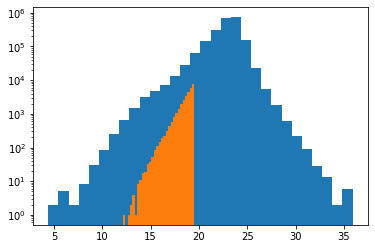

In [27]:
key = 'RMAG'
finite = np.isfinite(cat[key])
plt.hist(cat[key][finite], 30, log=True)
plt.hist(cat[key][bgsb], 30, log=True)

In [30]:
(cat['RMAG'][bgsb] < 13).sum()

2